### Double DQN

In [2]:
import random
import gymnasium as gym
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import rl_utils
from tqdm import tqdm


class Qnet(torch.nn.Module):
    ''' 只有一层隐藏层的Q网络 '''
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(Qnet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

In [20]:
class DQN:
    ''' DQN算法,包括Double DQN '''
    def __init__(self,
                 state_dim,
                 hidden_dim,
                 action_dim,
                 learning_rate,
                 gamma,
                 epsilon,
                 target_update,
                 device,
                 dqn_type='VanillaDQN'):
        self.action_dim = action_dim
        self.q_net = Qnet(state_dim, hidden_dim, self.action_dim).to(device)
        self.target_q_net = Qnet(state_dim, hidden_dim,
                                 self.action_dim).to(device)
        self.optimizer = torch.optim.Adam(self.q_net.parameters(),
                                          lr=learning_rate)
        self.gamma = gamma
        self.epsilon = epsilon
        self.target_update = target_update
        self.count = 0
        self.dqn_type = dqn_type
        self.device = device
    
    def take_action(self, state):
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.action_dim)
        else:
            state = torch.tensor([state], dtype=torch.float).to(self.device)
            action = self.q_net(state).argmax().item()
        return action
    
    def max_q_value(self, state):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        return self.q_net(state).max().item()
    
    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'],dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'],dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'],dtype=torch.float).view(-1, 1).to(self.device)

        q_values = self.q_net(states).gather(1, actions)  # Q值
        # 下个状态的最大Q值
        if self.dqn_type == 'VanillaDQN':
            #普通DQN的情况
            max_next_q_values = self.target_q_net(next_states).max(1)[0].view(-1,1) #[0] 取最大值
        else:
            max_action = self.q_net(next_states).max(1)[1].view(-1,1) #[1] 取最大值的索引
            #也可以这样写 
            #max_action = self.q_net(next_state).argmax(1).view(-1,1)
            max_next_q_values = self.target_q_net(next_states).gather(1, max_action) #延维度一取索引

        q_targets = rewards + self.gamma * max_next_q_values * (1 - dones)
        dqn_loss = torch.mean(F.mse_loss(q_values, q_targets))
        self.optimizer.zero_grad()
        dqn_loss.backward()
        self.optimizer.step()

        if self.count % self.target_update == 0:
            self.target_q_net.load_state_dict(
                self.q_net.state_dict())  # 更新目标网络
        self.count += 1

In [30]:
lr = 1e-2
num_episodes = 200
hidden_dim = 128
gamma = 0.98
epsilon = 0.01
target_update = 100
buffer_size = 5000
minimal_size = 1000
batch_size = 64
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")

env_name = 'Pendulum-v1'
env = gym.make(env_name)
state_dim = env.observation_space.shape[0]
print(env.observation_space)
print(env.action_space)
action_dim = 11  # 将连续动作分成11个离散动作

def dis_to_con(discrete_action, env, action_dim):
    action_lowbound = env.action_space.low[0]  #box 类型不可以直接索引
    action_upperbound = env.action_space.high[0]
    return action_lowbound + (discrete_action / (action_dim - 1)) * (action_upperbound - action_lowbound)

print(dis_to_con(0,env,action_dim))

Box([-1. -1. -8.], [1. 1. 8.], (3,), float32)
Box(-2.0, 2.0, (1,), float32)
-2.0


In [31]:
import collections

class ReplayBuffer:
    '''
    经验回放池
    1. 保证数据的独立同分布
    2. 提升样本利用效率
    '''
    def __init__(self,capacity):
        self.buffer = collections.deque(maxlen=capacity) #初始化一个双端队列.

    def add(self,state,action,reward,next_state,done):
        #将数据加入buffer
        self.buffer.append((state,action,reward,next_state,done))

    def sample(self,batch_size):
        # obtain sample form buffer, size is batch_size
        transition = random.sample(self.buffer,batch_size)
        #按列解包, state 数据通常是多维数据
        state_tuple, action_tuple, reward_tuple,next_state_tuple, done_tuple = zip(*transition)
        return np.array(state_tuple), action_tuple, reward_tuple, np.array(next_state_tuple), done_tuple

    def size(self):
        return len(self.buffer)

In [32]:
def train_DQN(agent, env, num_episodes, replay_buffer, minimal_size,
              batch_size):
    return_list = []
    max_q_value_list = []
    max_q_value = 0
    for i in range(10):
        with tqdm(total=int(num_episodes / 10),
                  desc='Iteration %d' % i) as pbar:
            for i_episode in range(int(num_episodes / 10)):
                episode_return = 0
                state,_ = env.reset(seed=0)
                done = False
                while not done:
                    action = agent.take_action(state)
                    max_q_value = agent.max_q_value(state) * 0.005 + max_q_value * 0.995  # 平滑处理
                    max_q_value_list.append(max_q_value)  # 保存每个状态的最大Q值
                    action_continuous = dis_to_con(action, env,agent.action_dim)
                    next_state, reward, terminated, truncated, _ = env.step([action_continuous])
                    done = terminated or truncated
                    replay_buffer.add(state, action, reward, next_state, done)
                    state = next_state
                    episode_return += reward
                    if replay_buffer.size() > minimal_size:
                        b_s, b_a, b_r, b_ns, b_d = replay_buffer.sample(batch_size)
                        transition_dict = {
                            'states': b_s,
                            'actions': b_a,
                            'next_states': b_ns,
                            'rewards': b_r,
                            'dones': b_d
                        }
                        agent.update(transition_dict)
                return_list.append(episode_return)
                if (i_episode + 1) % 10 == 0:
                    pbar.set_postfix({
                        'episode':'%d' % (num_episodes / 10 * i + i_episode + 1),
                        'return':'%.3f' % np.mean(return_list[-10:])
                    })
                pbar.update(1)
    return return_list, max_q_value_list

Iteration 0:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration 9: 100%|██████████| 20/20 [00:13<00:00,  1.46it/s, episode=200, return=-127.701]


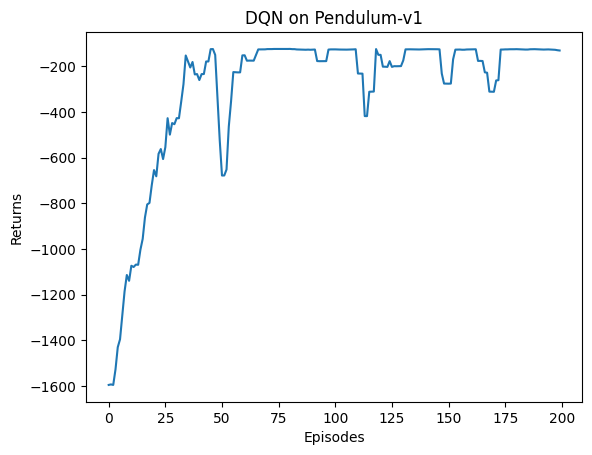

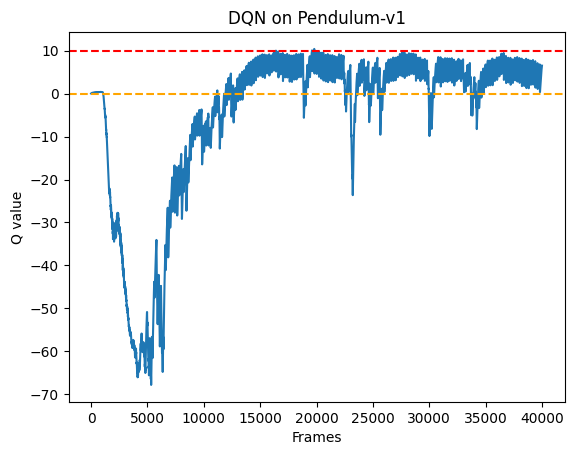

In [33]:
random.seed(0)
np.random.seed(0)

torch.manual_seed(0)
replay_buffer = rl_utils.ReplayBuffer(buffer_size)
agent = DQN(state_dim, hidden_dim, action_dim, lr, gamma, epsilon,
            target_update, device)
return_list, max_q_value_list = train_DQN(agent, env, num_episodes,
                                          replay_buffer, minimal_size,
                                          batch_size)

episodes_list = list(range(len(return_list)))
mv_return = rl_utils.moving_average(return_list, 5)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DQN on {}'.format(env_name))
plt.show()

frames_list = list(range(len(max_q_value_list)))
plt.plot(frames_list, max_q_value_list)
plt.axhline(0, c='orange', ls='--')
plt.axhline(10, c='red', ls='--')
plt.xlabel('Frames')
plt.ylabel('Q value')
plt.title('DQN on {}'.format(env_name))
plt.show()

Iteration 9: 100%|██████████| 20/20 [00:15<00:00,  1.32it/s, episode=200, return=-373.154]


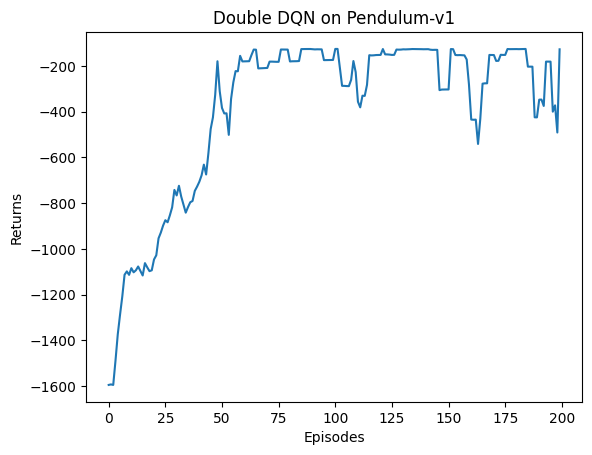

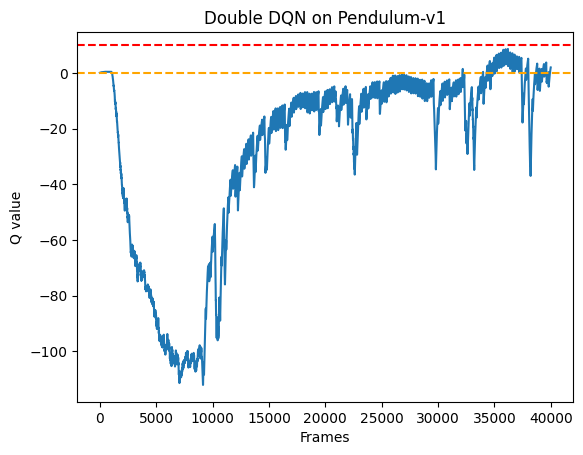

In [34]:
random.seed(0)
np.random.seed(0)

torch.manual_seed(0)
replay_buffer = rl_utils.ReplayBuffer(buffer_size)
agent = DQN(state_dim, hidden_dim, action_dim, lr, gamma, epsilon,
            target_update, device, 'DoubleDQN')
return_list, max_q_value_list = train_DQN(agent, env, num_episodes,
                                          replay_buffer, minimal_size,
                                          batch_size)

episodes_list = list(range(len(return_list)))
mv_return = rl_utils.moving_average(return_list, 5)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Double DQN on {}'.format(env_name))
plt.show()

frames_list = list(range(len(max_q_value_list)))
plt.plot(frames_list, max_q_value_list)
plt.axhline(0, c='orange', ls='--')
plt.axhline(10, c='red', ls='--')
plt.xlabel('Frames')
plt.ylabel('Q value')
plt.title('Double DQN on {}'.format(env_name))
plt.show()

### Dueling DQN

In [35]:
class VAnet(torch.nn.Module):
    ''' 只有一个隐藏层的A网络和V网络 '''
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(VAnet,self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc_A = torch.nn.Linear(hidden_dim, action_dim)
        self.fc_V = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x):
        A = self.fc_A(F.relu(self.fc1(x)))
        V = self.fc_V(F.relu(self.fc1(x)))
        Q = V + A - A.mean(1).view(-1,1)
        return Q   

In [36]:
class DQN:
    ''' DQN算法,包括Double DQN和Dueling DQN '''
    def __init__(self,state_dim,hidden_dim,action_dim,learning_rate,gamma,epsilon,
                 target_update,device,dqn_type='VanillaDQN'):
        self.action_dim = action_dim

        if dqn_type == 'DuelingDQN':  # Dueling DQN采取不一样的网络框架
            self.q_net = VAnet(state_dim, hidden_dim,self.action_dim).to(device)
            self.target_q_net = VAnet(state_dim, hidden_dim,self.action_dim).to(device)
        else:
            self.q_net = Qnet(state_dim, hidden_dim,self.action_dim).to(device)
            self.target_q_net = Qnet(state_dim, hidden_dim,self.action_dim).to(device)

        self.optimizer = torch.optim.Adam(self.q_net.parameters(),lr=learning_rate)
        self.gamma = gamma
        self.epsilon = epsilon
        self.target_update = target_update
        self.count = 0
        self.dqn_type = dqn_type
        self.device = device

    def take_action(self, state):
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.action_dim)
        else:
            state = torch.tensor([state], dtype=torch.float).to(self.device)
            action = self.q_net(state).argmax().item()
        return action

    def max_q_value(self, state):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        return self.q_net(state).max().item()

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'],dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'],dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'],dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'],dtype=torch.float).view(-1, 1).to(self.device)

        q_values = self.q_net(states).gather(1, actions)
        if self.dqn_type == 'DoubleDQN':
            max_action = self.q_net(next_states).max(1)[1].view(-1, 1)
            max_next_q_values = self.target_q_net(next_states).gather(1, max_action)
        else:
            max_next_q_values = self.target_q_net(next_states).max(1)[0].view(-1, 1)
        q_targets = rewards + self.gamma * max_next_q_values * (1 - dones)
        dqn_loss = torch.mean(F.mse_loss(q_values, q_targets))
        self.optimizer.zero_grad()
        dqn_loss.backward()
        self.optimizer.step()

        if self.count % self.target_update == 0:
            self.target_q_net.load_state_dict(self.q_net.state_dict())
        self.count += 1


Iteration 9: 100%|██████████| 20/20 [00:24<00:00,  1.20s/it, episode=200, return=-229.942]


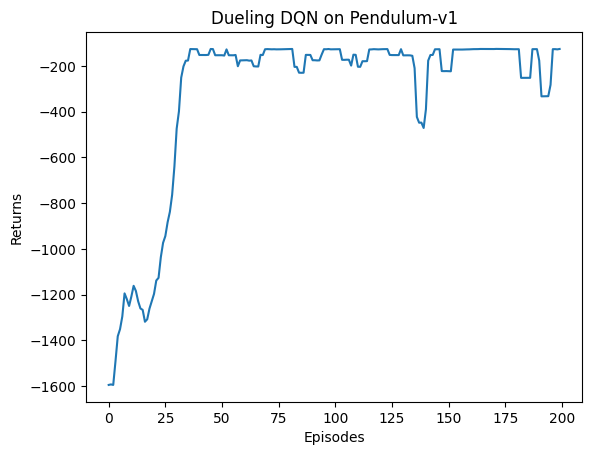

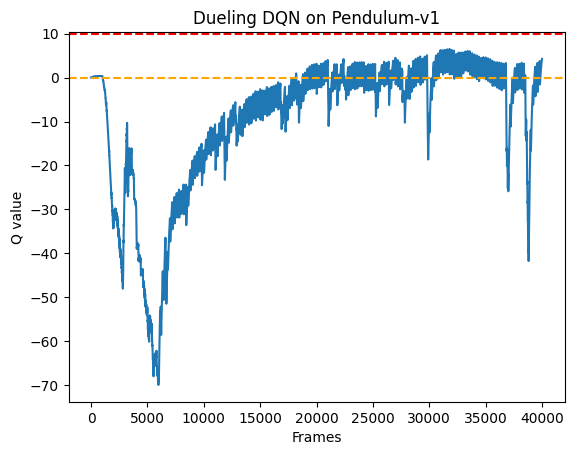

In [37]:
random.seed(0)
np.random.seed(0)

torch.manual_seed(0)
replay_buffer = rl_utils.ReplayBuffer(buffer_size)
agent = DQN(state_dim, hidden_dim, action_dim, lr, gamma, epsilon,target_update, device, 'DuelingDQN')
return_list, max_q_value_list = train_DQN(agent, env, num_episodes,replay_buffer, minimal_size,batch_size)

episodes_list = list(range(len(return_list)))
mv_return = rl_utils.moving_average(return_list, 5)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Dueling DQN on {}'.format(env_name))
plt.show()

frames_list = list(range(len(max_q_value_list)))
plt.plot(frames_list, max_q_value_list)
plt.axhline(0, c='orange', ls='--')
plt.axhline(10, c='red', ls='--')
plt.xlabel('Frames')
plt.ylabel('Q value')
plt.title('Dueling DQN on {}'.format(env_name))
plt.show()

### 尝试总结今天所学
#### 1. 为什么要改进DQN?
1. **DQN的高估问题**
   ✅ 核心原因：DQN使用`max(Q)`会系统性高估动作价值函数（Maximization Bias）。
   🔍 补充机制：
   - 贝尔曼方程中的最大操作会放大估计误差（如噪声或近似误差）。
   - 高估会导致策略偏向高风险动作，在部分场景（如稀疏奖励）中失效。

2. **DQN的更新效率问题**
   ✅ 你的观点：
   - DQN每次更新仅影响单个动作的Q值，Dueling DQN通过状态价值函数V同时影响该状态下所有动作的Q值。
   🔍 补充解释：
   - Dueling DQN的分解公式：
   
$$

     Q(s,a) = V(s) + \left( A(s,a) - \frac{1}{|A|} \sum_{a'} A(s,a') \right)
   
$$

   - 状态价值V的更新会间接修正所有动作的Q值，提升数据效率。

3. **状态价值的重要性**
   ✅ 你的观点：
   - 某些场景中，Agent更关心状态的整体价值（如靠近目标时的V(s)），而非单个动作的优势（A(s,a)）。
   🔍 典型场景：
   - 迷宫出口附近的状态价值更重要，动作选择对结果影响较小。

---

#### 2. 两种改进算法
##### 2.1 Double DQN
✅ 你的核心描述：
- **动作选择与值评估解耦**：在线网络选动作（`argmax Q_online`），目标网络评估Q值（`Q_target`）。
🔍 补充细节：
- **参数更新机制**：
  - 目标网络通过硬更新（定期复制）或软更新（如Polyak平均）与在线网络同步。
- **数学证明**：
  - 解耦后高估幅度降低约50%（见Hasselt et al., 2015）。

##### 2.2 Dueling DQN
✅ 你的核心描述：
- **Q值分解**：将Q函数分解为状态价值V(s)和优势函数A(s,a)。
🔍 补充细节：
- **网络结构**：
  ```python
  # 神经网络分支示例
  self.V = nn.Linear(hidden_dim, 1)          # 状态价值分支
  self.A = nn.Linear(hidden_dim, action_dim) # 优势函数分支